### Libraries and data loading

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates
import numpy.ma as ma
import CRPS.CRPS as pscore

%matplotlib inline

2025-04-28 00:11:48.877026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 00:11:48.999158: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 00:11:49.031849: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 00:11:49.639934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.10.0
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
available cpus: 112


2025-04-28 00:11:50.794061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:50.794376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:50.801275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:50.801548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:50.801777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
# define the data location and load data
data_folder = os.path.join("autodl-tmp")
data_path = os.path.join(data_folder, "video_prediction_dataset.hdf5")

# !change model name for different models!
model_name = 'SUNSET_forecast_2017_2019_data'
output_folder = os.path.join("model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: autodl-tmp
data_path: autodl-tmp/video_prediction_dataset.hdf5
output_folder: model_output/SUNSET_forecast_2017_2019_data


In [4]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (4 members)>
<HDF5 dataset "images_log": shape (4467, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "images_pred": shape (4467, 15, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (4467, 16), type "<f4">
<HDF5 dataset "pv_pred": shape (4467, 15), type "<f4">
<HDF5 group "/trainval" (4 members)>
<HDF5 dataset "images_log": shape (53336, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "images_pred": shape (53336, 15, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (53336, 16), type "<f4">
<HDF5 dataset "pv_pred": shape (53336, 15), type "<f4">


In [5]:
print('-'*50)
# get the input dimension for constructing the model
# the input images will be reshaped from (None, 8, 64, 64, 3) to (None, 64, 64, 24)
img_side_len = forecast_dataset['trainval']['images_log'].shape[2]
num_log_term = forecast_dataset['trainval']['images_log'].shape[1]
num_pred_term = forecast_dataset['trainval']['pv_pred'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[4]
image_input_dim = [img_side_len,img_side_len,num_log_term*num_color_channel]

print("image side length:", img_side_len)
print("number of log terms:", num_log_term)
print("number of pred terms:", num_pred_term)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

sample_ratio = 0.1
step = int(1/sample_ratio)  # 每隔5个取1个
selected_indices = np.arange(0, len(times_trainval), step)
times_trainval = times_trainval[selected_indices]

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
batch_size = 10000
num_samples = len(times_trainval)
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    _ = forecast_dataset['trainval']['pv_pred'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of log terms: 16
number of pred terms: 15
number of color channels: 3
input image dimension: [64, 64, 48]
times_trainval.shape: (53336,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 5333, 99.98% finished, processing time 0.68s


### Input data pipeline helper functions

In [6]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [7]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [8]:
def process_image(image_data):
    '''
    image data processing: reshaping and normalization
    '''
    ## reshape the image tensor from [None,8,64,64,3] to [None,64,64,24]
    image_data = tf.transpose(image_data,perm=[0,2,3,1,4])
    image_data = tf.reshape(image_data, [image_data.shape[0],image_data.shape[1],image_data.shape[2],-1])

    ## normalize the image to [0,1]
    image_data = tf.image.convert_image_dtype(image_data, tf.float32)

    return image_data

In [9]:
def data_loader(hdf5_data_path, sample_idx, batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx: 
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path, sample_idx):
        '''
        Map indices to corresponding images and pv_pred data in hdf5 (Python implementation)
        '''
        # Convert EagerTensor to string or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode()
        # Sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path, 'r') as f:
            # Read in the data
            images_log = f['trainval']['images_log'][sample_idx]  # Load image data
            pv_pred = f['trainval']['pv_pred'][sample_idx][:, -1]  # Load target (last value)

            # Process image data
            images_log = process_image(images_log)  # Assuming process_image is defined elsewhere

            # Convert data to TensorFlow tensors
            images_log = tf.convert_to_tensor(images_log, dtype=tf.float32)
            pv_pred = tf.convert_to_tensor(pv_pred, dtype=tf.float32)

            return images_log, pv_pred

    def mapping_func_tf(hdf5_data_path, sample_idx):
        '''
        Wrapper mapping function for TensorFlow compatibility
        '''
        images_log, pv_pred = tf.py_function(
            func=mapping_func_py, 
            inp=[hdf5_data_path, sample_idx], 
            Tout=(tf.float32, tf.float32)  # Single input and target
        )
        return images_log, pv_pred  # Return only images_log and pv_pred
    
    # Create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # Shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size=idx_ds.cardinality().numpy(), seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

    # Map the dataset to images and targets
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path, x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset


In [10]:
def compute_winkler_score(prob_prediction,observation):
    alpha = 0.1
    lb = np.percentile(prob_prediction,5,axis=0)
    ub = np.percentile(prob_prediction,95,axis=0)
    delta = ub-lb
    if observation<lb:
        sc = delta+2*(lb-observation)/alpha
    if observation>ub:
        sc = delta+2*(observation-ub)/alpha
    if (observation>=lb) and (observation<=ub):
        sc = delta
    return sc

### Model architecture

In [11]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

In [12]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D, 
                                    Flatten, Dropout, Dense, Multiply, 
                                    GlobalAveragePooling2D, Reshape)

# SE注意力模块
def se_attention(input_feature, reduction_ratio=16):
    """Squeeze-and-Excitation"""
    channels = input_feature.shape[-1]  # 获取通道数
    
    # Squeeze操作 (全局平均池化)
    x = GlobalAveragePooling2D()(input_feature)
    
    # Excitation操作 (两个全连接层)
    x = Dense(channels // reduction_ratio, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    
    # 调整形状以匹配输入tensor
    x = Reshape((1, 1, channels))(x)
    
    # 与原始输入相乘
    return Multiply()([input_feature, x])

def sunset_model():
    ## input
    x_in = keras.Input(shape=image_input_dim)  # Input image logs with shape (64,64,24)

    ## 1st convolution block
    x = Conv2D(num_filters // 2, kernel_size, padding="same", activation='relu')(x_in)
    x = BatchNormalization()(x)
    x = se_attention(x)  # 添加SE注意力
    x = MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = Conv2D(num_filters, kernel_size, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = se_attention(x)  # 添加SE注意力
    x = MaxPooling2D(pool_size, strides)(x)

    # Flatten the convolution output for connection with Dense layers
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)

    # Output layer for regression task
    y_out = Dense(units=1)(x)

    # Construct the model
    model = models.Model(inputs=x_in, outputs=y_out)

    # Compile the model with an optimizer
    optimizer = optimizers.Adam(learning_rate=learning_rate)  # 使用您定义的learning_rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Show model architecture
model = sunset_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 48)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 12)   5196        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 12)  48          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

2025-04-28 00:11:54.249677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 00:11:54.453217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:54.453522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-28 00:11:54.453758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

### Model training and validation

Repetition 1 model training started ...
Epoch 1/200


2025-04-28 00:12:00.441088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-04-28 00:12:02.951444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


19/19 [==============================] - ETA: 0s - loss: 256.0515
Epoch 1: val_loss improved from inf to 207.53706, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_1/best_model_repitition_1.h5
19/19 [==============================] - 66s 3s/step - loss: 256.0515 - val_loss: 207.5371
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 217.7377
Epoch 2: val_loss improved from 207.53706 to 206.56580, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_1/best_model_repitition_1.h5
19/19 [==============================] - 9s 512ms/step - loss: 217.7377 - val_loss: 206.5658
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 185.0494
Epoch 3: val_loss improved from 206.56580 to 203.73257, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_1/best_model_repitition_1.h5
19/19 [==============================] - 9s 509ms/step - loss: 185.0494 - val_loss: 203.7326
Epoch 4/200
19/19 [====================

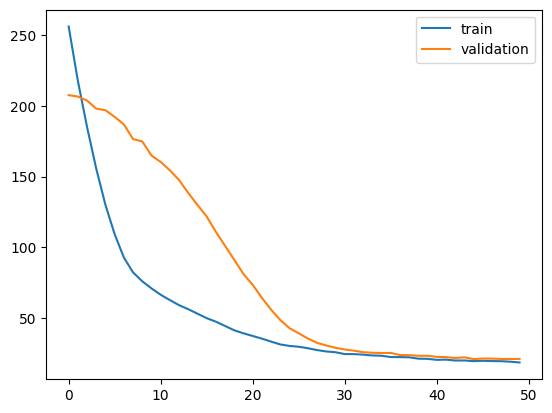

Repetition 2 model training started ...
Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 229.1981
Epoch 1: val_loss improved from inf to 276.01706, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_2/best_model_repitition_2.h5
19/19 [==============================] - 21s 963ms/step - loss: 229.1981 - val_loss: 276.0171
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 192.0620
Epoch 2: val_loss improved from 276.01706 to 270.93259, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_2/best_model_repitition_2.h5
19/19 [==============================] - 10s 526ms/step - loss: 192.0620 - val_loss: 270.9326
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 161.5724
Epoch 3: val_loss improved from 270.93259 to 265.86014, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_2/best_model_repitition_2.h5
19/19 [==============================] - 9s 519ms/step - loss: 161.5724 - va

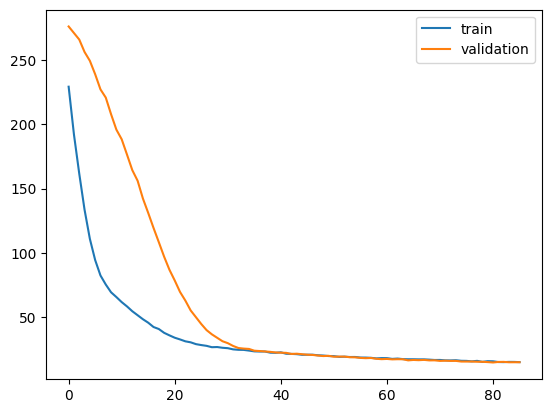

Repetition 3 model training started ...
Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 288.2994
Epoch 1: val_loss improved from inf to 259.09262, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_3/best_model_repitition_3.h5
19/19 [==============================] - 28s 1s/step - loss: 288.2994 - val_loss: 259.0926
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 246.2467
Epoch 2: val_loss improved from 259.09262 to 256.65555, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_3/best_model_repitition_3.h5
19/19 [==============================] - 9s 523ms/step - loss: 246.2467 - val_loss: 256.6555
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 211.4485
Epoch 3: val_loss improved from 256.65555 to 253.80261, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_3/best_model_repitition_3.h5
19/19 [==============================] - 9s 515ms/step - loss: 211.4485 - val_lo

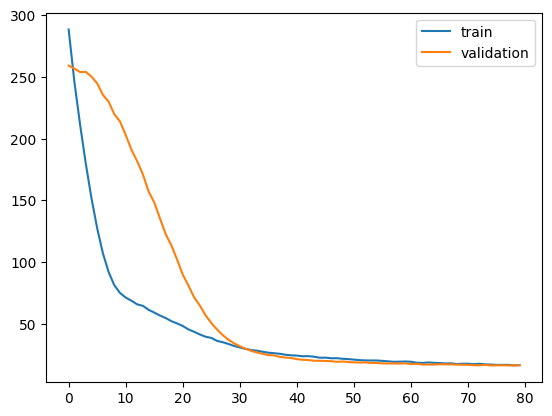

Repetition 4 model training started ...
Epoch 1/200
18/19 [===========================>..] - ETA: 0s - loss: 220.7913
Epoch 1: val_loss improved from inf to 244.98108, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_4/best_model_repitition_4.h5
19/19 [==============================] - 21s 1s/step - loss: 218.7786 - val_loss: 244.9811
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 184.7390
Epoch 2: val_loss improved from 244.98108 to 242.98987, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_4/best_model_repitition_4.h5
19/19 [==============================] - 16s 864ms/step - loss: 184.7390 - val_loss: 242.9899
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 155.8583
Epoch 3: val_loss improved from 242.98987 to 237.52017, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_4/best_model_repitition_4.h5
19/19 [==============================] - 9s 513ms/step - loss: 155.8583 - val_l

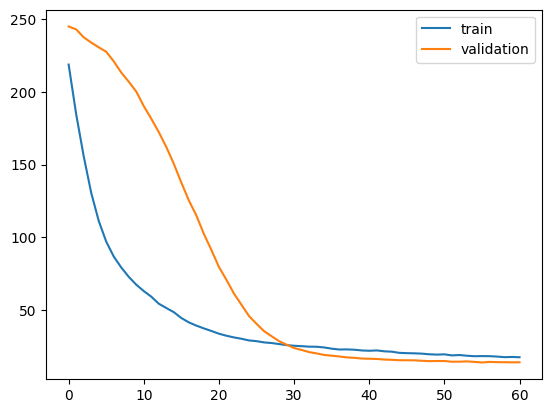

Repetition 5 model training started ...
Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 256.6793
Epoch 1: val_loss improved from inf to 306.00128, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_5/best_model_repitition_5.h5
19/19 [==============================] - 30s 1s/step - loss: 256.6793 - val_loss: 306.0013
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 217.3273
Epoch 2: val_loss improved from 306.00128 to 301.24728, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_5/best_model_repitition_5.h5
19/19 [==============================] - 10s 530ms/step - loss: 217.3273 - val_loss: 301.2473
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 184.2364
Epoch 3: val_loss did not improve from 301.24728
19/19 [==============================] - 9s 511ms/step - loss: 184.2364 - val_loss: 301.3032
Epoch 4/200
19/19 [==============================] - ETA: 0s - loss: 154.6845
Epoch 4: val_lo

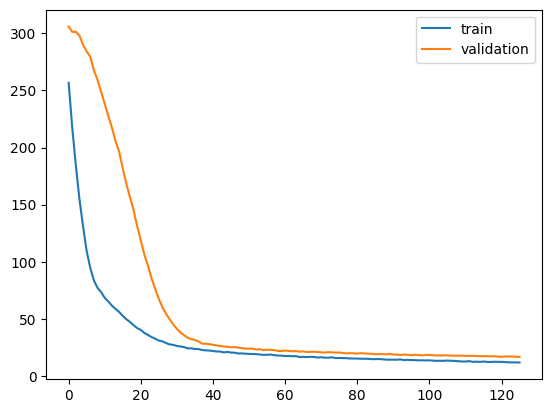

Repetition 6 model training started ...
Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 225.1779
Epoch 1: val_loss improved from inf to 330.79224, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_6/best_model_repitition_6.h5
19/19 [==============================] - 27s 1s/step - loss: 225.1779 - val_loss: 330.7922
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 191.7758
Epoch 2: val_loss improved from 330.79224 to 328.90549, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_6/best_model_repitition_6.h5
19/19 [==============================] - 10s 533ms/step - loss: 191.7758 - val_loss: 328.9055
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 162.9797
Epoch 3: val_loss improved from 328.90549 to 322.65591, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_6/best_model_repitition_6.h5
19/19 [==============================] - 10s 529ms/step - loss: 162.9797 - val_

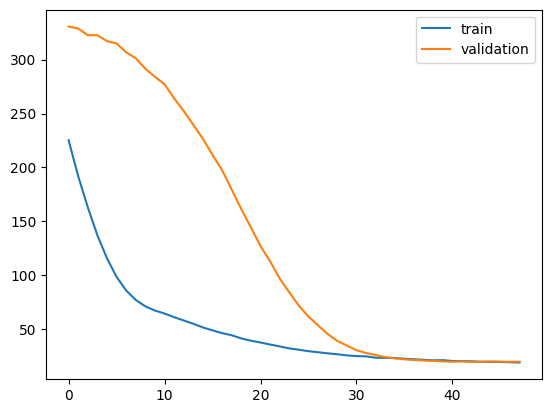

Repetition 7 model training started ...
Epoch 1/200
18/19 [===========================>..] - ETA: 0s - loss: 251.4529
Epoch 1: val_loss improved from inf to 182.14827, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_7/best_model_repitition_7.h5
19/19 [==============================] - 22s 1s/step - loss: 251.9299 - val_loss: 182.1483
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 211.2359
Epoch 2: val_loss did not improve from 182.14827
19/19 [==============================] - 9s 513ms/step - loss: 211.2359 - val_loss: 182.3132
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 175.4430
Epoch 3: val_loss improved from 182.14827 to 179.81725, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_7/best_model_repitition_7.h5
19/19 [==============================] - 10s 531ms/step - loss: 175.4430 - val_loss: 179.8172
Epoch 4/200
19/19 [==============================] - ETA: 0s - loss: 144.5902
Epoch 4: val_lo

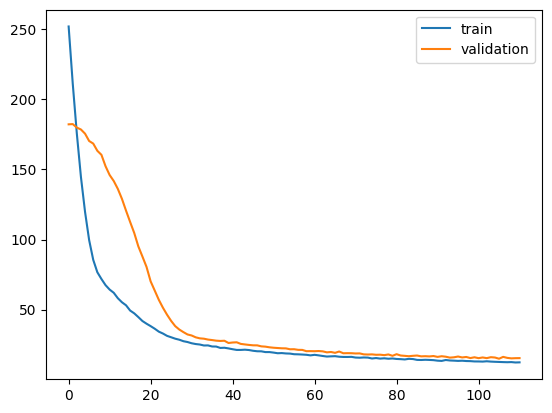

Repetition 8 model training started ...
Epoch 1/200
18/19 [===========================>..] - ETA: 0s - loss: 260.5943
Epoch 1: val_loss improved from inf to 270.72974, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_8/best_model_repitition_8.h5
19/19 [==============================] - 22s 1s/step - loss: 260.2118 - val_loss: 270.7297
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 221.0478
Epoch 2: val_loss improved from 270.72974 to 270.06973, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_8/best_model_repitition_8.h5
19/19 [==============================] - 10s 539ms/step - loss: 221.0478 - val_loss: 270.0697
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 188.7292
Epoch 3: val_loss improved from 270.06973 to 266.37531, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_8/best_model_repitition_8.h5
19/19 [==============================] - 9s 519ms/step - loss: 188.7292 - val_l

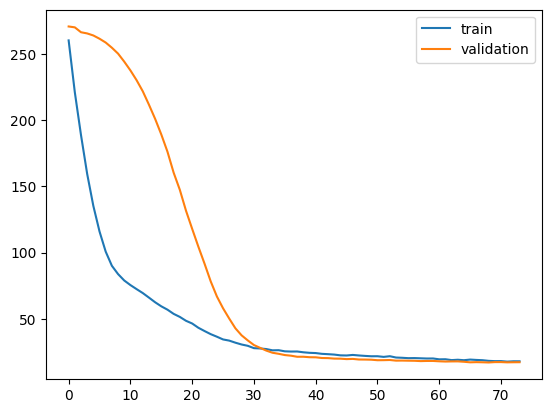

Repetition 9 model training started ...
Epoch 1/200
18/19 [===========================>..] - ETA: 0s - loss: 224.8468
Epoch 1: val_loss improved from inf to 232.34862, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_9/best_model_repitition_9.h5
19/19 [==============================] - 22s 1s/step - loss: 222.6974 - val_loss: 232.3486
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 187.2943
Epoch 2: val_loss improved from 232.34862 to 229.34270, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_9/best_model_repitition_9.h5
19/19 [==============================] - 10s 531ms/step - loss: 187.2943 - val_loss: 229.3427
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 156.5945
Epoch 3: val_loss improved from 229.34270 to 229.00696, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_9/best_model_repitition_9.h5
19/19 [==============================] - 9s 520ms/step - loss: 156.5945 - val_l

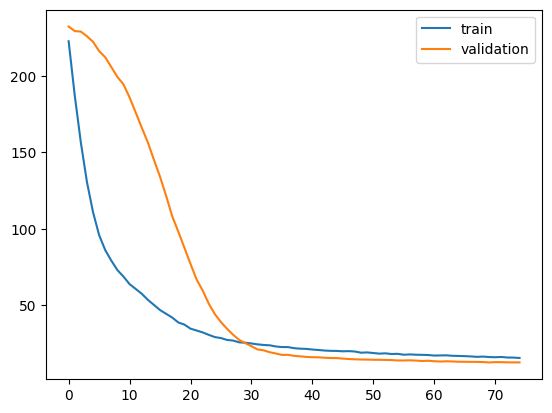

Repetition 10 model training started ...
Epoch 1/200
18/19 [===========================>..] - ETA: 0s - loss: 223.7069
Epoch 1: val_loss improved from inf to 246.42273, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_10/best_model_repitition_10.h5
19/19 [==============================] - 23s 1s/step - loss: 221.7789 - val_loss: 246.4227
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 187.9806
Epoch 2: val_loss did not improve from 246.42273
19/19 [==============================] - 9s 515ms/step - loss: 187.9806 - val_loss: 247.8432
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 158.4848
Epoch 3: val_loss improved from 246.42273 to 245.41115, saving model to model_output/SUNSET_forecast_2017_2019_data/repetition_10/best_model_repitition_10.h5
19/19 [==============================] - 9s 523ms/step - loss: 158.4848 - val_loss: 245.4111
Epoch 4/200
19/19 [==============================] - ETA: 0s - loss: 133.3871
Epoch 4: va

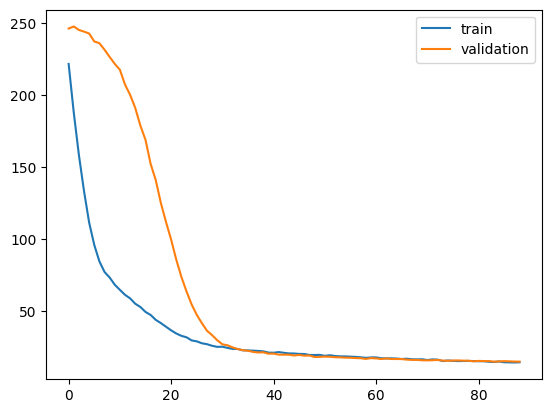

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [13]:
# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []
    
for i in range(num_fold):
    
    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),loss='mse')
    
    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))
    
    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder,'repetition_'+str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path,indices_train)
    ds_val_batched = data_loader(data_path,indices_val,batch_size=500)

    # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'), 
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])

    # plot training and validation history
    plt.plot(train_loss_hist[i],label='train')
    plt.plot(val_loss_hist[i],label='validation')
    plt.legend()
    plt.show()

# saving model training and validation loss history
np.save(os.path.join(output_folder,'train_loss_hist.npy'),train_loss_hist)
np.save(os.path.join(output_folder,'val_loss_hist.npy'),val_loss_hist)

In [14]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 4.44, validation loss: 4.60 (RMSE)
Model 2  -- train loss: 3.96, validation loss: 3.85 (RMSE)
Model 3  -- train loss: 4.13, validation loss: 4.05 (RMSE)
Model 4  -- train loss: 4.28, validation loss: 3.73 (RMSE)
Model 5  -- train loss: 3.51, validation loss: 4.08 (RMSE)
Model 6  -- train loss: 4.49, validation loss: 4.41 (RMSE)
Model 7  -- train loss: 3.56, validation loss: 3.87 (RMSE)
Model 8  -- train loss: 4.27, validation loss: 4.12 (RMSE)
Model 9  -- train loss: 4.03, validation loss: 3.57 (RMSE)
Model 10  -- train loss: 3.81, validation loss: 3.84 (RMSE)
The mean train loss (RMSE) for all models is 4.05
The mean validation loss (RMSE) for all models is 4.01


### Model testing

In [22]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)


with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_pred_test = f['test']['pv_pred'][...][:,-1]

print("images_log_test.shape:",images_log_test.shape)
print("pv_pred_test.shape:",pv_pred_test.shape)

times_test.shape: (4467,)
images_log_test.shape: (4467, 16, 64, 64, 3)
pv_pred_test.shape: (4467,)


In [23]:
# process image data
images_log_test = (images_log_test/255.0).astype('float32')

In [24]:
# Set batch size
batch_size = 100
num_batches = len(images_log_test) // batch_size + int(len(images_log_test) % batch_size > 0)

# Infer shape dynamically
first_batch = process_image(images_log_test[:batch_size]).numpy()
images_log_test_processed = np.zeros((len(images_log_test),) + first_batch.shape[1:], dtype=first_batch.dtype)

# Process in smaller batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(images_log_test))
    batch = images_log_test[start_idx:end_idx]
    processed_batch = process_image(batch).numpy()

    # Save processed batch into the pre-allocated array
    images_log_test_processed[start_idx:end_idx] = processed_batch

print("Final processed shape:", images_log_test_processed.shape)


Final processed shape: (4467, 64, 64, 48)


In [25]:
def preprocess_images(image_data):
    """
    Complete preprocessing pipeline (must match training pipeline exactly)
    Input: Raw image data (5D: batch, timesteps, height, width, channels)
    Output: Model-ready 4D input (batch, height, width, channels)
    """
    # Step 1: Transpose dimensions (batch, height, width, timesteps, channels)
    image_data = np.transpose(image_data, [0, 2, 3, 1, 4])
    
    # Step 2: Merge last two dimensions (batch, height, width, timesteps*channels)
    image_data = np.reshape(image_data, [image_data.shape[0], 64, 64, -1])
    
    # Step 3: Ensure correct data type and range
    image_data = image_data.astype('float32') / 255.0
    
    return image_data

In [26]:
import gc
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

batch_size = 32

# Preprocess entire test set (more efficient)
processed_test_images = preprocess_images(images_log_test)
print("Final processed shape:", processed_test_images.shape)  # Should be (4467,64,64,48)

# Initialize prediction array
ensemble_predictions = np.zeros(len(times_test))

for fold_idx in range(num_fold):
    print(f"Loading model {fold_idx + 1}...")
    model = keras.models.load_model(
        os.path.join(output_folder, f'repetition_{fold_idx+1}', f'best_model_repitition_{fold_idx+1}.h5')
    )
    
    # Verify model input shape
    print(f"Model input shape: {model.input_shape}")
    
    # Batch prediction
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(times_test))
        
        batch_images = processed_test_images[start_idx:end_idx]
        
        # Final shape verification
        assert batch_images.shape[1:] == model.input_shape[1:], \
            f"Shape mismatch! Data{batch_images.shape[1:]} ≠ Model{model.input_shape[1:]}"
        
        batch_predictions = model.predict(batch_images, verbose=0)
        ensemble_predictions[start_idx:end_idx] += np.squeeze(batch_predictions) / num_fold
    
    del model
    gc.collect()
    
loss_ensemble = np.sqrt(np.mean((prediction_ensemble - pv_pred_test) ** 2))
print('-' * 50)
print(f"The test set RMSE is {loss_ensemble:.3f} for the ensemble model")


Final processed shape: (4467, 64, 64, 48)
Loading model 1...
Model input shape: (None, 64, 64, 48)
Loading model 2...
Model input shape: (None, 64, 64, 48)
Loading model 3...
Model input shape: (None, 64, 64, 48)
Loading model 4...
Model input shape: (None, 64, 64, 48)
Loading model 5...
Model input shape: (None, 64, 64, 48)
Loading model 6...
Model input shape: (None, 64, 64, 48)
Loading model 7...
Model input shape: (None, 64, 64, 48)
Loading model 8...
Model input shape: (None, 64, 64, 48)
Loading model 9...
Model input shape: (None, 64, 64, 48)
Loading model 10...
Model input shape: (None, 64, 64, 48)
--------------------------------------------------
The test set RMSE is 11.434 for the ensemble model


In [27]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    pv_pred_test = f['test']['pv_pred'][...][:,-1]

print("pv_pred_test.shape:",pv_pred_test.shape)

times_test.shape: (4467,)
pv_pred_test.shape: (4467,)


In [28]:
from sklearn.metrics import r2_score, explained_variance_score

# Load predictions from each model
prediction = np.load(os.path.join(output_folder, 'test_predictions.npy'))

# Using the ensemble mean of the 10 models as the final prediction
prediction_ensemble = np.mean(prediction, axis=0)

# RMSE
loss_ensemble = np.sqrt(np.mean((prediction_ensemble - pv_pred_test) ** 2))
print("The test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

# MAE
MAE = np.mean(np.abs((prediction_ensemble - pv_pred_test)))
print("The test set MAE is {0:.3f} for the ensemble model".format(MAE))

# R²
R2 = r2_score(pv_pred_test, prediction_ensemble)
print("The test set R² is {0:.3f} for the ensemble model".format(R2))

# Explained Variance Score (EVS)
EVS = explained_variance_score(pv_pred_test, prediction_ensemble)
print("The test set EVS is {0:.3f} for the ensemble model".format(EVS))


The test set RMSE is 3.927 for the ensemble model
The test set MAE is 2.792 for the ensemble model
The test set R² is 0.655 for the ensemble model
The test set EVS is 0.655 for the ensemble model


In [29]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_pred_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

The mean crps: 2.505


In [30]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_pred_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

The mean Winkler score: 42.571


In [31]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,5,20),(2017,10,7),(2017,11,1),
        (2018,5,28),(2018,6,29),(2018,10,13),
        (2019,6,23),(2019,7,31),(2019,8,13),(2019,10,21)]
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [32]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

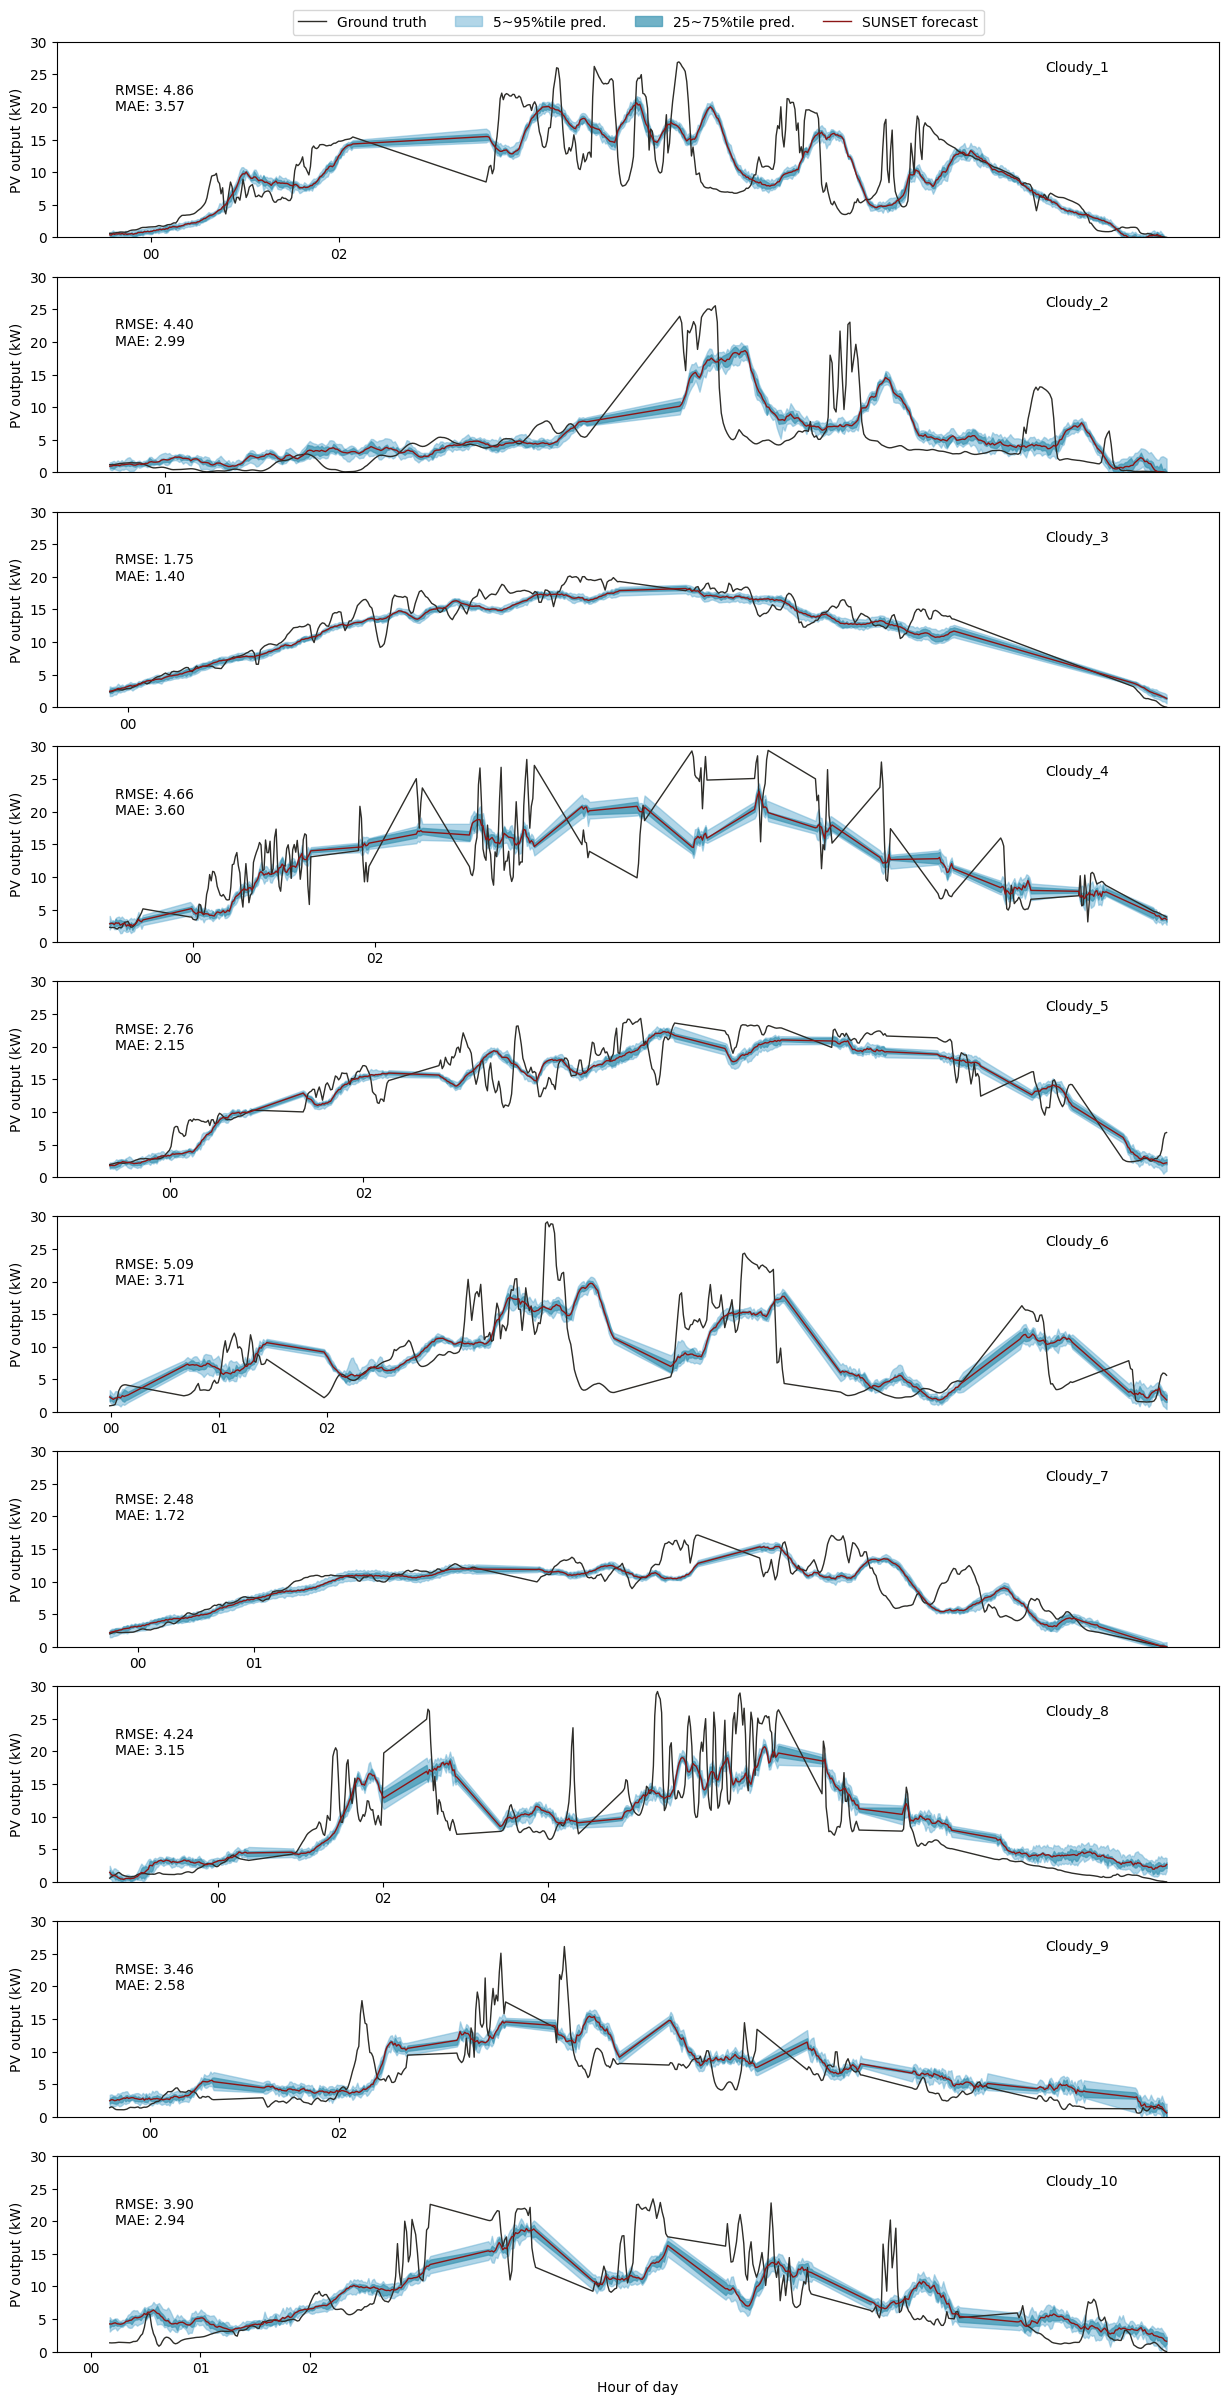

In [33]:
# visualization of forecast prediction_ensembles
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1, color=black, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1, label = 'SUNSET forecast',color=red,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.2], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,30)
plt.show()